In [1]:
#import all helpful libraries
import scipy.io, scipy.optimize 
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import h5py
import pandas as pd
import Preprocessing as pp

# Import and Preperation of Data

In [2]:
data = {}
foldername = "../Data/Raw_Data/Messdaten_Test_ID_1/"
temp_data_folder = "../Data/Temp_Data/"

pp.checkFolder(temp_data_folder)


mat_raw_files = ['n_soll.mat', 'P_el_rms.mat', 'P_th.mat', 't_el_rms.mat', 't_nsoll.mat', 't_th.mat']
for file in mat_raw_files:
    path = os.path.join(foldername, file)
    mat_file = scipy.io.loadmat(path)
    search = file[:-4]
    switcher = { #switcher is neccessary since files and matlab headers are not identical
        'n_soll': 'n_soll',
        'P_el_rms': 'P_elrms',
        'P_th': 'P_th',
        't_el_rms': 't_el_mean',
        't_nsoll': 't_2A_ela',
        't_th': 't_1B_th'
    }
    data[search] = mat_file[switcher.get(search)]

Folder already exists.


In [3]:
# edit and subsample data where neccessary
data_nsoll = data['n_soll'][0::1000]
data_p_elrms = data['P_el_rms'][0]
data_p_th = data['P_th'][0][0::10]
data_t_nsoll = data['t_nsoll'].T[0::1000]
data_t_elrms = data['t_el_rms'][0]
data_t_th = data['t_th'][0][0::10]

### Saving files in TempData Folder

In [26]:
df = pd.DataFrame()
df['spinning_soll'] = pp.downsampleData(data_t_nsoll, data_nsoll, sample_size=11975)[:,1]
df['time'] = pp.downsampleData(data_t_nsoll, data_t_nsoll, sample_size=11975)[:,1]
df['el_power'] = pp.downsampleData(data_t_elrms, data_p_elrms, sample_size=11975)[:,1]
df['th_power'] = pp.downsampleData(data_t_th, data_p_th, sample_size=11975)[:,1]

time_splits = [0, 1, 3605, 3606, 5811, 5812, 8429, 8430, 11294, 11295, len(df['time'])]
voltage_splits = [0, 10, 10, 3, 3, 10, 10, 3, 3, 0, 0]
dummy, df['input_voltage'] = pp.fillData(time_splits, voltage_splits)

In [27]:
value_splits = [df['spinning_soll'].iloc[t] for t in time_splits[:-1]]
value_splits.append(df['spinning_soll'].iloc[-1])

In [47]:
time = df['time']
input_voltage = df['input_voltage']
spinning_soll = df['spinning_soll']

11981.12314


In [48]:
time_splits = [int(time[i]) for i in range(len(time)-1) if abs(input_voltage[i] - input_voltage[i+1]) > 0.01]
value_splits = [int(spinning_soll[i]) for i in range(len(spinning_soll)-1) if abs(input_voltage[i] - input_voltage[i+1]) > 0.01]
time_splits.insert(0, 0)
value_splits.insert(0, spinning_soll[0])
time_splits.append(int(time[len(time)-1]))
value_splits.append(int(time[len(spinning_soll)-1]))

In [49]:
def hardConstraint(time_splits, values_splits, m = 2.16):
    time = np.array(range(int(time_splits[-1])))
    values = np.array(range(int(time_splits[-1])))
    for i in range(len(time_splits)-1):
        lower = int(time_splits[i])
        upper = int(time_splits[i+1])
        v_low = values_splits[i]
        v_up = values_splits[i+1]
        slope = min(m, ((v_up - v_low)/(upper-lower)))
        for t in range(upper-lower):
            values[lower + t] = v_low + slope *t
    return time, values

In [53]:
dummy, spin_ist = pp.applyConstraint(time_splits, value_splits)
df['spinning_ist'] = spin_ist[:11975]

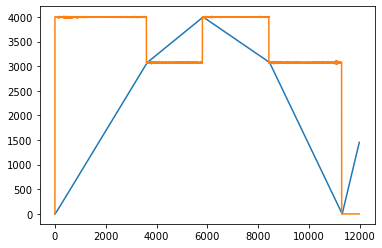

In [54]:
plt.plot(df['time'], df['spinning_ist'])
plt.plot(df['time'], df['spinning_soll'])

In [9]:
df.to_csv(temp_data_folder + "experiment_1.csv",
                    index = False, sep = "|", encoding='utf-8')

In [10]:
df_short = df[800:-1250]

In [11]:
df_short.to_csv(temp_data_folder + "experiment_1_short.csv",
                    index = False, sep = "|", encoding='utf-8')

# Visualization of raw Data

The following figures show the development over time of thermal output (blue), electrical output (orange) or the 'Drehzahlsollwert" (green). The last figure shows a correlation between those measures.

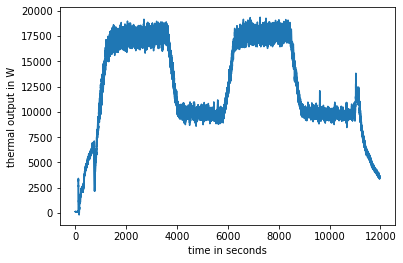

In [12]:
plt.plot(data_t_th, data_p_th)
plt.xlabel("time in seconds")
plt.ylabel("thermal output in W")
plt.show()

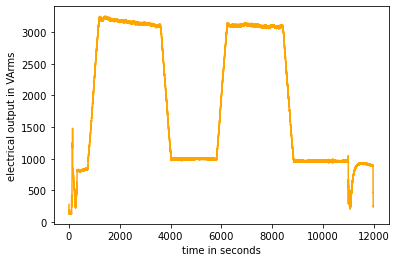

In [13]:
plt.plot(data_t_elrms, data_p_elrms, 'orange')
plt.xlabel("time in seconds")
plt.ylabel("electrical output in VArms")
plt.show()

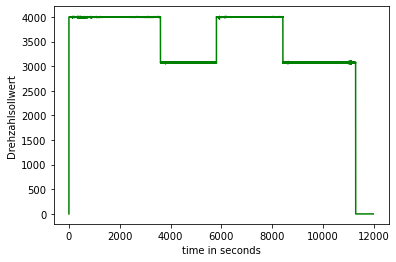

In [14]:
plt.plot(data_t_nsoll, data_nsoll, 'green')
plt.xlabel("time in seconds")
plt.ylabel("Drehzahlsollwert")
plt.show()

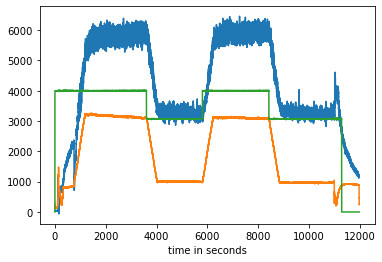

In [15]:
plt.plot(data_t_th, data_p_th/3)
plt.plot(data_t_elrms, data_p_elrms)
plt.plot(data_t_nsoll, data_nsoll)
plt.xlabel("time in seconds")
plt.show()

The experiment consists of 4 different phases, each with following durations:<br/>
0% -> 100%: 60 minutes (3600 secs -> change after 3605)<br/>
100% -> 30%: 36,75 minutes (2200 secs -> change after 5811)<br/>
30% -> 100%: 42 minutes (2500 secs -> change after 8429)<br/>
100% -> 30% 50 minutes (3000 secs -> change after 11294)

30% -> 0%: 11,5 minutes (690 secs -> ends at 11981)

In [16]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [17]:
def createTimeSubplots(time_data, values, color):
    fig,axs = plt.subplots(2, 3, figsize = (20,12))
    axs = axs.ravel()
    axs[0].plot(time_data, values, color)
    
    for t in range(len(time_splits)-1):
        data_part = values[(time_splits[t]+1)*5:time_splits[t+1]*5]
        time_part = time_data[(time_splits[t]+1)*5:time_splits[t+1]*5]
        rm = running_mean(data_part,300)
        axs[t+1].plot(time_part, data_part, color)
        axs[t+1].plot(time_part[299:], rm, color='yellow')
    
    plt.show()

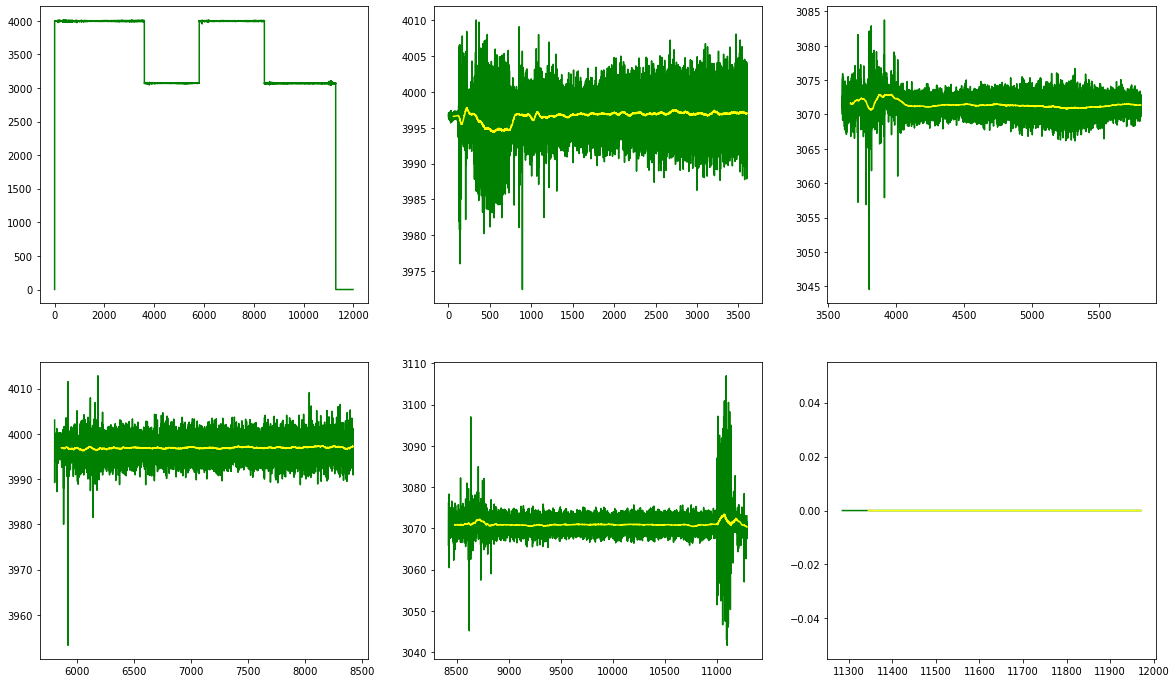

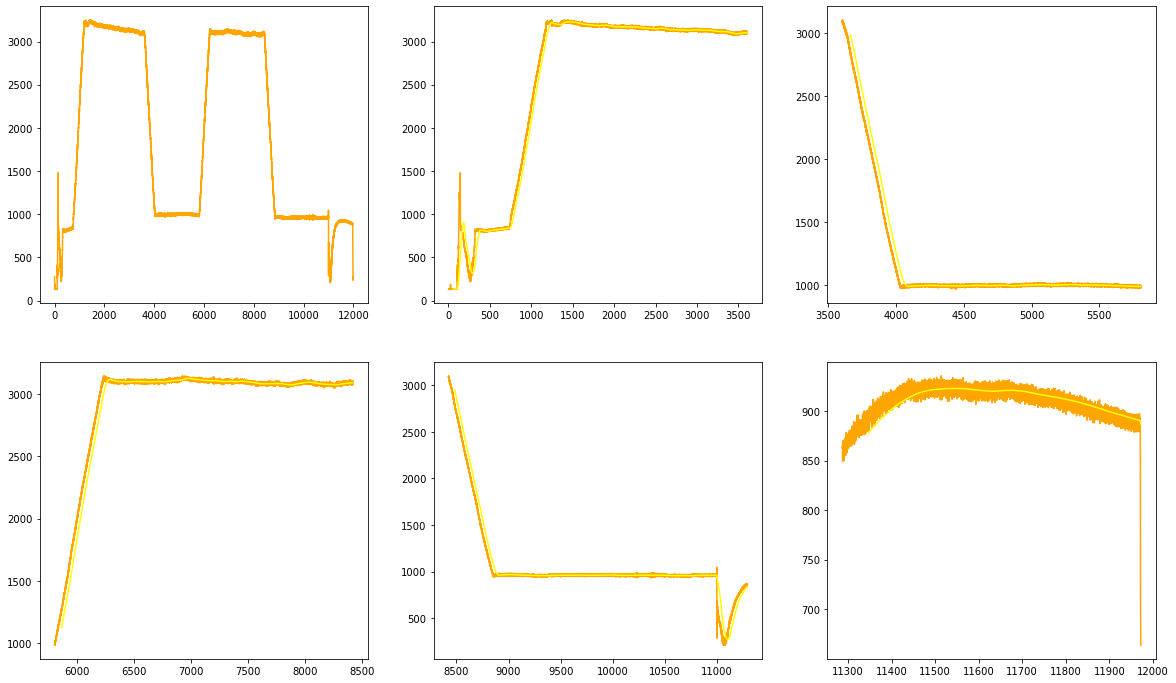

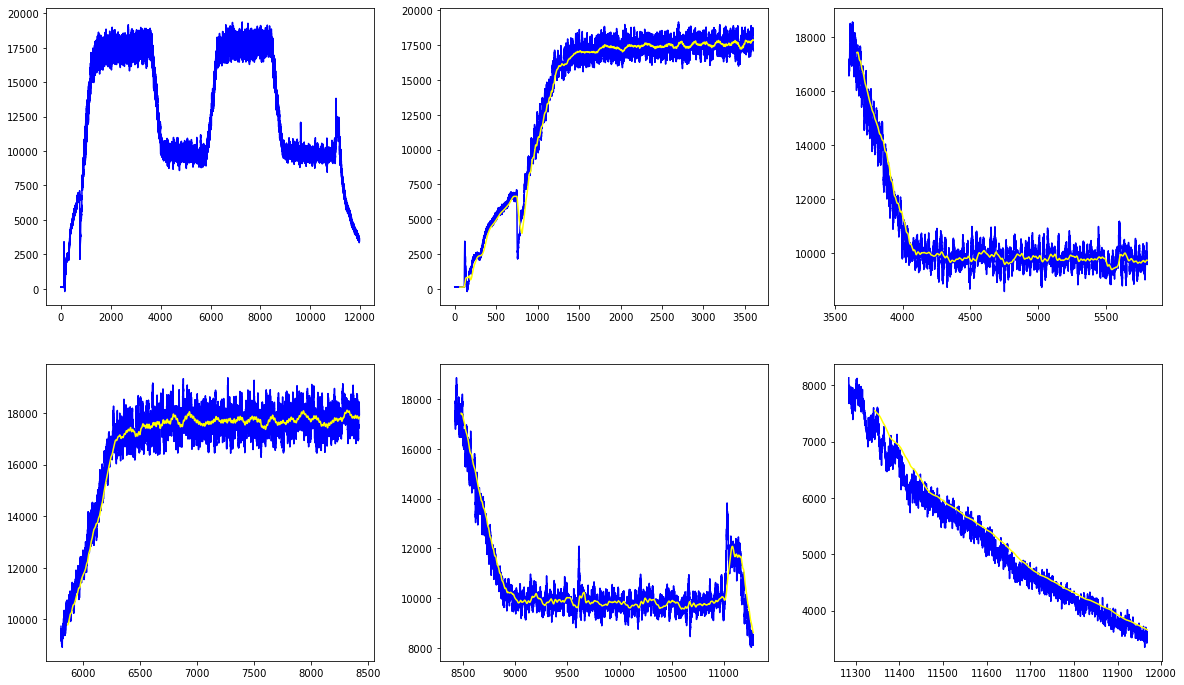

In [18]:
time_splits = [1, 3605, 5811, 8429, 11294, 11981]

createTimeSubplots(data_t_nsoll, data_nsoll, 'green')
createTimeSubplots(data_t_elrms, data_p_elrms, 'orange')
createTimeSubplots(data_t_th, data_p_th, 'blue')

# Comparison of data with theoretical baseline

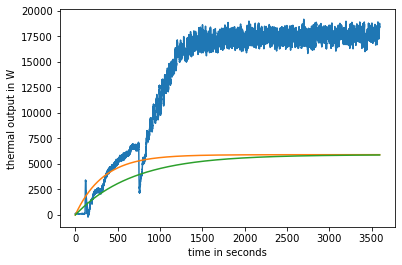

In [19]:
time_start = data_t_th[:18000]
k = 5900
plt.plot(time_start, data_p_th[:18000])
plt.plot(time_start, -k* np.exp((-1/330)*time_start) +k)
plt.plot(time_start, -k* np.exp((-1/680)*time_start) +k)
plt.xlabel("time in seconds")
plt.ylabel("thermal output in W")
plt.show()

In [20]:
para_fit = scipy.optimize.curve_fit(lambda t,k, tau: -k* np.exp((-1/tau)*t) +k, time_start, data_p_th[:18000])
k_best = para_fit[0][0]
tau_best = para_fit[0][1]
tau_best

<ipython-input-20-f6b6998b19dc>:1: RuntimeWarning: overflow encountered in exp
  para_fit = scipy.optimize.curve_fit(lambda t,k, tau: -k* np.exp((-1/tau)*t) +k, time_start, data_p_th[:18000])
<ipython-input-20-f6b6998b19dc>:1: RuntimeWarning: overflow encountered in multiply
  para_fit = scipy.optimize.curve_fit(lambda t,k, tau: -k* np.exp((-1/tau)*t) +k, time_start, data_p_th[:18000])


1122.672207332912

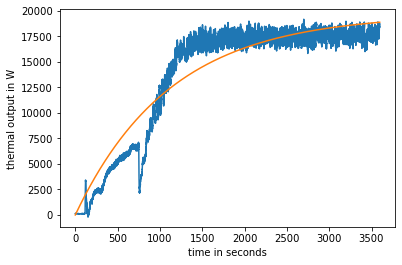

In [21]:
plt.plot(time_start, data_p_th[:18000])
plt.plot(time_start, -k_best* np.exp((-1/tau_best)*time_start) +k_best)
plt.xlabel("time in seconds")
plt.ylabel("thermal output in W")
plt.show()

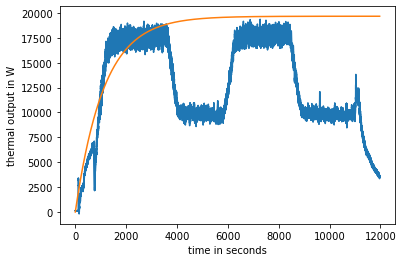

In [22]:
plt.plot(data_t_th, data_p_th)
plt.plot(data_t_th, -k_best* np.exp((-1/tau_best)*data_t_th) +k_best)
plt.xlabel("time in seconds")
plt.ylabel("thermal output in W")
plt.show()